# Ensamble Models
**Authors**: Vilhelm Stiernstedt, Sharon Marín Salazar & Andrea Tondella
<br>
**Date**: 26/05/2018

In this final section we will collect our best models with their optimized parameters and text processers. We will set up the their pipeline and then integrate them into a soft ensamble, even split more or less. Our models used are:
- SGD
- Multi-NB
- Sequential NN

## Import Libraries

In [15]:
# general libs
import collections
import time
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse import hstack
import warnings

# nltk libs
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

# keras libs
from keras.wrappers.scikit_learn import KerasClassifier
from keras import metrics as kerasMetrics
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM

# sklearn libs
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# mlxtend libs (ensamle / stacking)
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.classifier import StackingClassifier

# Warning settings -> suppress depreciation warnings
warnings.filterwarnings('ignore')

## Import Data

In [16]:
# set path to data
data_path = 'data/'

# load test and train
df_train = pd.read_csv(data_path+'training_clean.csv')
df_test = pd.read_csv(data_path+'fake_or_real_news_test.csv')

# set index
df_train.set_index('ID', inplace=True)
df_test.set_index('ID', inplace=True)

# define combined df
all_data = df_train.append(df_test)

## Text Processing

#### Stemmers

In [17]:
# define count vectorizer for modelling (different parameter inputs will be given in modelling)
count_vectorizer = CountVectorizer()

### define SnowballStemmer w. NLTK extension
snowball_stemmer = SnowballStemmer("english")
# define count vectorizer w. SnowballStemmer
class SnowballCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(SnowballCountVectorizer, self).build_analyzer()
        return lambda doc: ([snowball_stemmer.stem(w) for w in analyzer(doc)])
    
### define PorterStemmer w. NLTK extension
porter_stemmer = PorterStemmer(mode='NLTK_EXTENSIONS')
# define count vectorizer w. PorterStemmer
class PorterCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(PorterCountVectorizer, self).build_analyzer()
        return lambda doc: ([porter_stemmer.stem(w) for w in analyzer(doc)])

#### Variable Selection

In [18]:
# create different feature subsets
x = df_train.text

#### Label

In [19]:
# define labelencoder and preprocess label
le = LabelEncoder()
y = le.fit_transform(df_train.label)

# Fake = 0
# Real = 1

#### Split Data

In [20]:
# split training data and labels into train and validation 80/20
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2, 
                                                    random_state=42)

### Model 1 - SGD

In [21]:
# define vectorizer
sgd_vect = SnowballCountVectorizer(lowercase=True, ngram_range=(1, 2), stop_words=None)

# define model -> use of loss=log as we need probabilty for ensamble -> lowers score slightly
sgd_clf = SGDClassifier(alpha=0.1, l1_ratio=0.75, loss='log', n_iter=800)

# define pipeline
sgd_pipeline = Pipeline([('vect', sgd_vect), ('clf', sgd_clf)])

# define paramters
alpha=[0.1]
l1_ratio=[0.75]
loss=['log']
n_iter=[800]

# insert into dict
sgd_param_grid = dict(clf__alpha=alpha, clf__l1_ratio=l1_ratio,
                      clf__loss=loss, clf__n_iter=n_iter)

# specify randsearch gird
#seq_m_grid = GridSearchCV(estimator=sgd_pipeline,
#                          param_grid=sgd_param_grid,
#                          n_jobs=1, cv=3)

# fit model pipelineg
#seq_m_grid.fit(x_train, y_train)
sgd_pipeline.fit(x_train, y_train)

# make predictions
#sgd_mod_pred = seq_m_grid.best_estimator_.predict(x_test)
sgd_mod_pred = sgd_pipeline.predict(x_test)

# model evaluation
print(metrics.classification_report(y_test, sgd_mod_pred, digits=3))

             precision    recall  f1-score   support

          0      0.895     0.935     0.914       383
          1      0.938     0.899     0.918       417

avg / total      0.917     0.916     0.916       800



### Model 2 - MultiNB

In [13]:
# define vectorizer
mnb_vect = CountVectorizer(ngram_range=(1, 3), stop_words=None, max_df=0.75)

# define feature selector
mnb_sel = SelectKBest(k=10)

# define model
mnb_clf = MultinomialNB(alpha=0.25)

# define pipeline
mnb_pipeline = Pipeline([('vect', mnb_vect), ('clf', mnb_clf)]) #('sel', mnb_sel), 

# define parameters
alpha=[0.25]
k=[10, 25, 50, 100, None]

# insert into dict
mnb_param_grid = dict(clf__alpha=alpha) # , sel__k=k)

# specify randsearch gird
mnb_m_grid = GridSearchCV(estimator=mnb_pipeline,
                          param_grid=mnb_param_grid,
                          n_jobs=1, cv=2)

# fit model pipelineg
#mnb_m_grid.fit(x_train, y_train)
mnb_pipeline.fit(x_train, y_train)

# make predictions
#mnb_m_grid_pred = mnb_m_grid.best_estimator_.predict(x_test)
mnb_m_grid_pred = mnb_pipeline.predict(x_test)

# model evaluation
print(metrics.classification_report(y_test, mnb_m_grid_pred, digits=3))

             precision    recall  f1-score   support

          0      0.958     0.885     0.920       383
          1      0.901     0.964     0.932       417

avg / total      0.928     0.926     0.926       800



### Model 3 - Sequential Multilayer Network

#### Define Functions

In [22]:
# define sequential model
def create_simple_model(optimizer='adam', init='glorot_uniform', dropout_rate=0.2, num_max=5000):
    model = Sequential()
    # first layer
    model.add(Dense(512,
                    activation='relu',
                    input_shape=(num_max,),
                    kernel_initializer=init)
             ) 
    model.add(Dropout(dropout_rate)) # dropout
    # second layer
    model.add(Dense(256,
                    activation='relu',
                    kernel_initializer=init)
             )
    model.add(Dropout(dropout_rate)) # dropout 
    # out_layer
    model.add(Dense(1,
                    activation='sigmoid',
                    kernel_initializer=init)
             )
    # summary
    model.summary()
    # compiler
    model.compile(loss='binary_crossentropy',  # loss function
              optimizer=optimizer, # optimizer
              metrics=['acc', kerasMetrics.binary_accuracy]) # metric 
    print('compile done')
    return model

In [23]:
# define tokenizer with fit_on_text and texts_to_matrix for pipeline
class TotalTokenizer(Tokenizer, BaseEstimator, TransformerMixin):
    """Tokenzier with fit_on_text and texts_to_matrix for pipelines."""
    def __init__(self, num_words=5000, lower=True, mode='count', **kwargs):
        super().__init__(**kwargs)
        self.num_words = num_words
        self.lower = lower
        
    def fit(self, texts, y=None):
        self.fit_on_texts(texts)
        return self
    
    def transform(self, texts, mode='count', y=None):
        return np.array(self.texts_to_matrix(texts, mode = mode))

#### Pipeline

In [24]:
# define vectorizer
seq_vect = TotalTokenizer(num_words=5000, lower=True, mode='count')

# define model -> maybe increase dropout as model might currently overfit
seq_clf = KerasClassifier(build_fn=create_simple_model, verbose=0,
                          batch_size=32, epochs=10)

# define pipeline
seq_pipeline = make_pipeline(seq_vect, seq_clf)

# fit model pipelineg
seq_pipeline.fit(x_train, y_train)

# make predictions
seq_m_grid_pred = seq_pipeline.predict(x_test)

# model evaluation
print(metrics.classification_report(y_test, seq_m_grid_pred, digits=3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               2560512   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 2,692,097
Trainable params: 2,692,097
Non-trainable params: 0
_________________________________________________________________
compile done
             precision    recall  f1-score   support

          0      0.896     0.969     0.931       383
          1 

### Ensemble Models
We will try both soft and hard voting and also different weights to find the best combination. We will try to use all three models but also only use two, to see if the meta classifier finds it easier to decide best model for different classes.

In [25]:
# Define Ensemble classifers
clf1 = sgd_pipeline # for soft: 0.33 voting right
clf2 = mnb_pipeline # for soft: 0.34 voting right -> highest avg.
clf3 = seq_pipeline # for soft: 0.33 voting right
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], voting='soft', weights=[0.34,0.33,0.33])

# Define name of models and stack classifier
labels = ['SGD', 'Multi_NB', 'Seq_NN', 'Ensemble']

# Define classifer list
clf_list = [clf1, clf2, clf3, eclf]

In [26]:
# Assing empty lists for cross validation mean scores and std
clf_cv_mean = []
clf_cv_std = []

# Cross validate each model and plot average score 
# use of orginal x and y -> no test/validation spit as no prediction will be made
for clf, label in zip(clf_list, labels):
    scores = cross_val_score(clf, x, y, cv=3)
    print("Accuracy: %0.3f (+/- %0.3f) [%s]"
          % (scores.mean(), scores.std(), label))
    # add mean and sd to lists
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())

Accuracy: 0.911 (+/- 0.006) [SGD]
Accuracy: 0.895 (+/- 0.009) [Multi_NB]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               2560512   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 2,692,097
Trainable params: 2,692,097
Non-trainable params: 0
_________________________________________________________________
compile done
______________________________________________

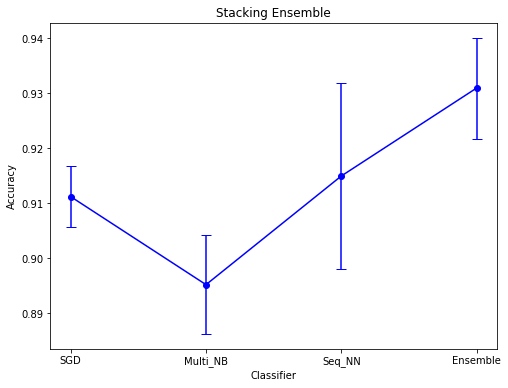

In [27]:
# Plot the accurancy of the different models
plt.figure(figsize=(8, 6))
(_, caps, _) = plt.errorbar(range(4), clf_cv_mean, yerr=clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)

plt.xticks(range(4), ['SGD', 'Multi_NB', 'Seq_NN', 'Ensemble'])
plt.ylabel('Accuracy'); plt.xlabel('Classifier'); plt.title('Stacking Ensemble');
plt.show()

### Final Model
Unfortuantely we did not mange to combine our three induvidually good models to create better model. Probably as the negative class is over represented and the other models fail at doing decent predictions of this class. We will use the svm - ovr model for the final prediction of the test dataset.

In [28]:
# Fit model
eclf.fit(x, y)

# Make predictions for test data, input into new df
final_predictions = pd.DataFrame(eclf.predict(df_test.text))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 512)               2560512   
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 257       
Total params: 2,692,097
Trainable params: 2,692,097
Non-trainable params: 0
_________________________________________________________________
compile done


### Submission

In [31]:
# New df
submission = pd.DataFrame()

# Import id from test_data index
submission['id'] = df_test.index

# import status_group predictions 
submission['label'] = final_predictions

# convert numerical to description
submission.loc[submission.label == 0, 'label'] = 'Fake'
submission.loc[submission.label == 1, 'label'] = 'Real'

# Preview
submission.head()

,id,label
0,10498,Fake
1,2439,Real
2,864,Real
3,4128,Real
4,662,Real


In [32]:
# Write submission to csv
submission.to_csv('submission_final.csv', sep=',', index=False)